# Financial Fraud Detection
---

### The Data
The data used for this analysis is a synthetically generated digital transactions dataset using a simulator called PaySim. PaySim simulates mobile money transactions based on a sample of real transactions extracted from one month of financial logs from a mobile money service implemented in an African country. It aggregates anonymized data from the private dataset to generate a synthetic dataset and then injects fraudulent transactions.<br><br>
View data here: https://www.kaggle.com/datasets/ealaxi/paysim1<br><br>
Class variable: `isFraud`

In [255]:
import pandas as pd
from IPython.display import display

df = pd.read_csv('fraud-detection-syn-dataset.csv')
del df['isFlaggedFraud']

df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
0,1,PAYMENT,9839.64,C1231006815,170136.00,160296.36,M1979787155,0.00,0.00,0
1,1,PAYMENT,1864.28,C1666544295,21249.00,19384.72,M2044282225,0.00,0.00,0
2,1,TRANSFER,181.00,C1305486145,181.00,0.00,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.00,C38997010,21182.00,0.00,1
4,1,PAYMENT,11668.14,C2048537720,41554.00,29885.86,M1230701703,0.00,0.00,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.00,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.00,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.00,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.00,C2080388513,0.00,0.00,1


### Data Cleaning

In [256]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
dtype: object

Now, we get the summary statistics of this `pandas dataframe` which will be done in two bits:
1. Summary of 'Numerical' attributes:

In [257]:
desc_df_num = df.describe([.25, .5, .75])
desc_df_num

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00


2. Summary of 'Categorical' columns:<br><br>
In this section only the count, unique values and mode of data hold importance.

In [258]:
desc_df_cat = df.describe(include="object")
desc_df_cat

,type,nameOrig,nameDest
count,6362620,6362620,6362620
unique,5,6353307,2722362
top,CASH_OUT,C1902386530,C1286084959
freq,2237500,3,113


Now we move forward to check for missing values in our dataset, and handle them depending on the number of missing values, column-wise.

In [259]:
df.isnull().values.any()

False

The output of the above code block suggest are no `nulls` in our dataset.

### Exploratory Data Analysis

As can be seen from the above <b>table</b> `desc_df_cat`, the number of legitimate (<b>non-fraudulent</b>) transactions (`isFraud = 0`) is very high compared to the fraudulent ones.


In [260]:
df.isFraud.value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

We only have `~0.13%` fraudulent transactions in our dataset (as would be the case in the real world), which creates an <b><i>imbalance</i></b> in our class variable `isFraud` —> <b>Class Imbalance</b>.

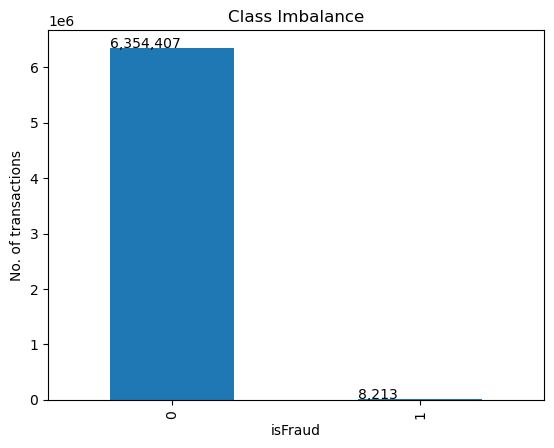

In [261]:
import matplotlib.pyplot as plt

axes = pd.value_counts(df['isFraud'], sort = True).sort_index().plot(kind = 'bar', title = 'Class Imbalance')

for p in axes.patches:
    axes.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()))
    axes.set_xlabel('isFraud')
    axes.set_ylabel('No. of transactions')
plt.show()

As we can see from these results, our class variable contains data which is highly skewed towards the <i>flag</i> value `0`, which would indeed affect any models we might <b>train</b> on this dataset.

Moving on to the attribute `type`—types of transactions:

In [262]:
df['type'].unique()

array(['PAYMENT', 'TRANSFER', 'CASH_OUT', 'DEBIT', 'CASH_IN'],
      dtype=object)

<Axes: >

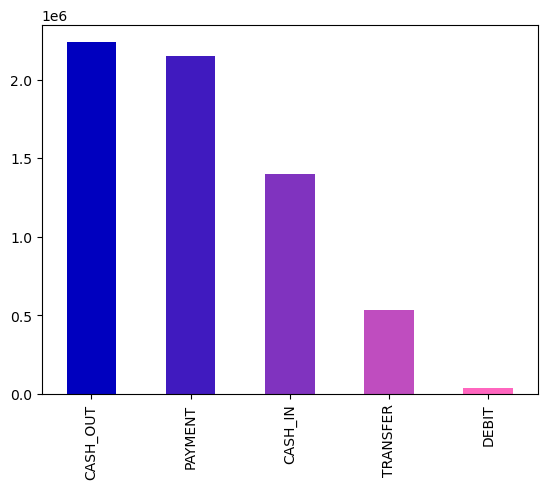

In [263]:
plotColours = [(x/4, x/10, 0.75) for x in range(10)]
df['type'].value_counts().plot.bar(color = plotColours)

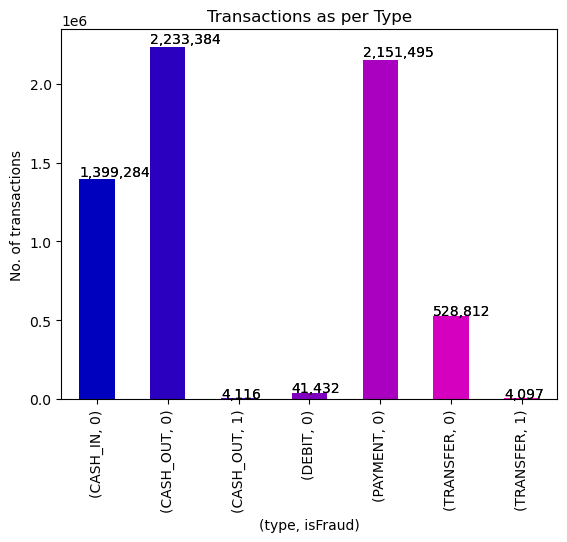

In [264]:
plotColours = [(x/6, x/10000, 0.75) for x in range(10)]
axes = df.groupby(['type', 'isFraud']).size().plot.bar(color = {'violet', 'green', 'purple', 'orange', 'teal', 'brown'})
axes = df.groupby(['type', 'isFraud']).size().plot.bar(color = plotColours)
axes.set_title('Transactions as per Type')
axes.set_xlabel('(type, isFraud)')
axes.set_ylabel('No. of transactions')
for p in axes.patches:
    axes.annotate(str(format(int(p.get_height()), ',d')), (p.get_x(), p.get_height()*1.01))

This plot shows us that only `type` `CASH_OUT` and `type` `TRANSFER` transactions can be <i>fraudulent</i>, and we can therefore remove the entries which have a different transaction `type`.

In [265]:
df = df.loc[~(df['type'].isin(['CASH_IN', 'DEBIT', 'PAYMENT']))]
df

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
2,1,TRANSFER,181.00,C1305486145,181.00,0.0,C553264065,0.00,0.00,1
3,1,CASH_OUT,181.00,C840083671,181.00,0.0,C38997010,21182.00,0.00,1
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.0,C476402209,5083.00,51513.44,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.0,C1100439041,22425.00,0.00,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.0,C932583850,6267.00,2719172.89,0
...,...,...,...,...,...,...,...,...,...,...
6362615,743,CASH_OUT,339682.13,C786484425,339682.13,0.0,C776919290,0.00,339682.13,1
6362616,743,TRANSFER,6311409.28,C1529008245,6311409.28,0.0,C1881841831,0.00,0.00,1
6362617,743,CASH_OUT,6311409.28,C1162922333,6311409.28,0.0,C1365125890,68488.84,6379898.11,1
6362618,743,TRANSFER,850002.52,C1685995037,850002.52,0.0,C2080388513,0.00,0.00,1


Only the transactions of `CASH_OUT type` and `TRANSFER type` are retained in out dataframe now, and the updated dataframe now has a total of `2770409` transactions, the data which earlier had `>6mil` tuples.<br><br>
We shall now check the percentge of <i>fraudulent</i> transactions shared among these two categories for a better understanding of the distribution of the same.

CASH_OUT    0.501157
TRANSFER    0.498843
Name: type, dtype: float64

<Axes: ylabel='type'>

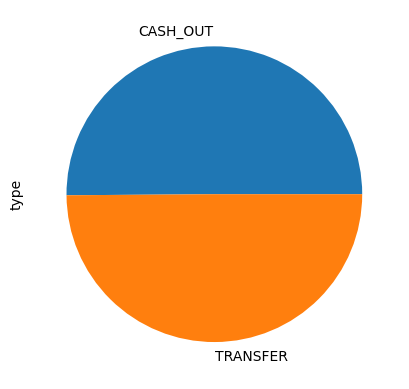

In [266]:
data_fraud = df[df.isFraud == 1] 
display(data_fraud.type.value_counts(normalize=True))
data_fraud.type.value_counts().plot.pie()

As can be seen from the above chart and figures, `isFraud = 1` transactions are almost equally distributed among `type CASH_OUT` and `TRANSFER` in the ratio `0.501:0.499`.

Now we will move on to checking the transactions where `amount` is `zero`.

In [267]:
df_zeroAmtTxns = df.loc[df['amount'] == 0]
len(df_zeroAmtTxns), df_zeroAmtTxns[['type', 'isFraud']]


(16,
              type  isFraud
 2736447  CASH_OUT        1
 3247298  CASH_OUT        1
 3760289  CASH_OUT        1
 5563714  CASH_OUT        1
 5996408  CASH_OUT        1
 5996410  CASH_OUT        1
 6168500  CASH_OUT        1
 6205440  CASH_OUT        1
 6266414  CASH_OUT        1
 6281483  CASH_OUT        1
 6281485  CASH_OUT        1
 6296015  CASH_OUT        1
 6351226  CASH_OUT        1
 6362461  CASH_OUT        1
 6362463  CASH_OUT        1
 6362585  CASH_OUT        1)

There are `16` such transactions, the `type` for all of them is `CASH_OUT`, and all of these transactions are `FRAUDULENT`.
<br><br>
We now shall move on to analyzing the originators' & recipients' balances.
Finding the number of transactions where `oldbalanceOrg` or `newbalanceDest` `=0`:

In [268]:
f"`oldbalanceOrg` == 0: {round(len(df.loc[df['oldbalanceOrg'] == 0])*100/len(df), 2)}%, `newbalanceDest` == 0: {round(len(df.loc[df['newbalanceDest'] == 0])*100/len(df), 2)}%" 

'`oldbalanceOrg` == 0: 47.23%, `newbalanceDest` == 0: 0.6%'

It is seen that in almost half of the transactions, the originator's initial balance was recorded as `zero`.
<br><br>
In an ideal scenario, the `newbalanceDest == oldbalanceDest + amount`, and `newbalanceOrig == oldbalanceOrg - amount`. We will now check these conditions.

In [269]:
df.loc[df['newbalanceOrig'] != df['oldbalanceOrg'] - df['amount']]

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud
15,1,CASH_OUT,229133.94,C905080434,15325.00,0.00,C476402209,5083.0,51513.44,0
19,1,TRANSFER,215310.30,C1670993182,705.00,0.00,C1100439041,22425.0,0.00,0
24,1,TRANSFER,311685.89,C1984094095,10835.00,0.00,C932583850,6267.0,2719172.89,0
42,1,CASH_OUT,110414.71,C768216420,26845.41,0.00,C1509514333,288800.0,2415.16,0
47,1,CASH_OUT,56953.90,C1570470538,1942.02,0.00,C824009085,70253.0,64106.18,0
...,...,...,...,...,...,...,...,...,...,...
6362462,730,TRANSFER,7316255.05,C1869569059,17316255.05,17316255.05,C1861208726,0.0,0.00,1
6362506,734,TRANSFER,10000000.00,C1891630790,11810044.85,1810044.85,C2124431731,0.0,0.00,1
6362528,736,TRANSFER,10000000.00,C412961249,11314660.84,1314660.84,C253674970,0.0,0.00,1
6362582,741,TRANSFER,10000000.00,C1945606464,15674547.89,5674547.89,C625944676,0.0,0.00,1


In [270]:
f"Txns. where Originators' balances are not accurately captured: {round((len(df.loc[df['newbalanceOrig'] != df['oldbalanceOrg'] - df['amount']])*100/len(df)), 2)}%"

"Txns. where Originators' balances are not accurately captured: 93.72%"

In [271]:
f"Txns. where Recipients' balances are not accurately captured: {round((len(df.loc[df['newbalanceDest'] != df['oldbalanceDest'] + df['amount']])*100/len(df)), 2)}%"

"Txns. where Recipients' balances are not accurately captured: 42.09%"

So, in most transactions, Originators' balances are not accurately captured, and in about two-fifths of the transactions, the Recipients' balances are not accurately captured.

Now, we will explore if any of the variables directly help us identify the `FRAUDULENT` transactions.
<br>
##### 1. Time `step` variable:
The number of txns. in each time `step` along with the `isFraud` flag is to be measured to identify (if any) the time steps where there are higher number of fraudulent transactions.

In [272]:
df[['step', 'isFraud']]

,step,isFraud
2,1,1
3,1,1
15,1,0
19,1,0
24,1,0
...,...,...
6362615,743,1
6362616,743,1
6362617,743,1
6362618,743,1


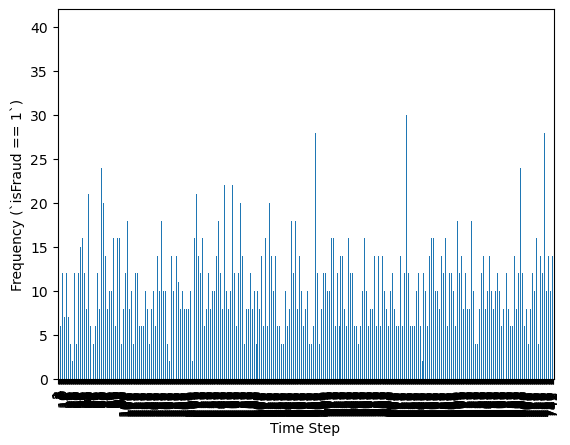

In [273]:
df_fraud = df['isFraud'].isin([1])

fraud_time = df[df_fraud].groupby(['step']).size().plot(kind='bar')
fraud_time.set_xlabel('Time Step')
fraud_time.set_ylabel('Frequency (`isFraud == 1`)')
plt.show()

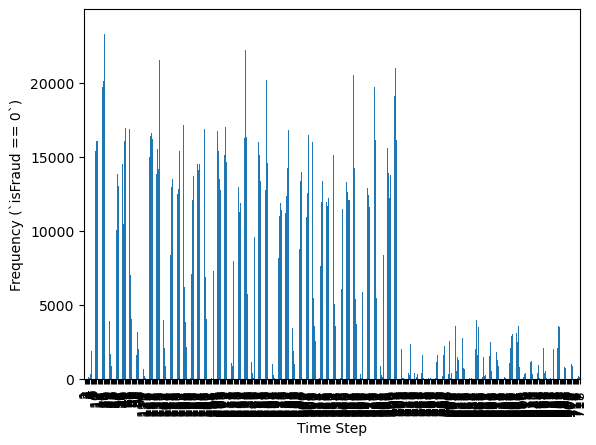

In [274]:
df_fraud = df['isFraud'].isin([0])

fraud_time = df[df_fraud].groupby(['step']).size().plot(kind='bar')
fraud_time.set_xlabel('Time Step')
fraud_time.set_ylabel('Frequency (`isFraud == 0`)')
plt.show()

Here, we can see that though the `FRAUDULENT` transactions are uniformly spread across `time`, the `NON-FRAUDULENT` trasactions are more concentrated in specific `time steps`, and so the feature `step` seems to be important for classification. Let us convert this `step`, a unit of which is a denotion of an `hour` in real time, starting from `00:00`, through a period of `31 days`, down into integers ranging from `0` to `24` hece signifying `hour of the day`.


In [275]:
day = 1
for ind in df['step'].index:
    i = df['step'].at[ind]

    if i > [j for j in range(24, 800, 24)][day - 1]:
        day += 1

    df['step'].at[ind] = (i - ((day - 1) * 24))


/var/folders/w8/l7g1xptx17d36m8h5qskbkxc0000gn/T/ipykernel_978/1143589317.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['step'].at[ind] = (i - ((day - 1) * 24))


In [276]:
df['step'].unique()

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24])

##### 2. Transaction `amount` variable:
We will now try to find out if there lies any relationship between `isFraud` and the transacrtion `amount`:

In [277]:
df['amount']
df_fraud = df['isFraud'].isin([0])
df_fraud
df.amount

2              181.00
3              181.00
15          229133.94
19          215310.30
24          311685.89
              ...    
6362615     339682.13
6362616    6311409.28
6362617    6311409.28
6362618     850002.52
6362619     850002.52
Name: amount, Length: 2770409, dtype: float64

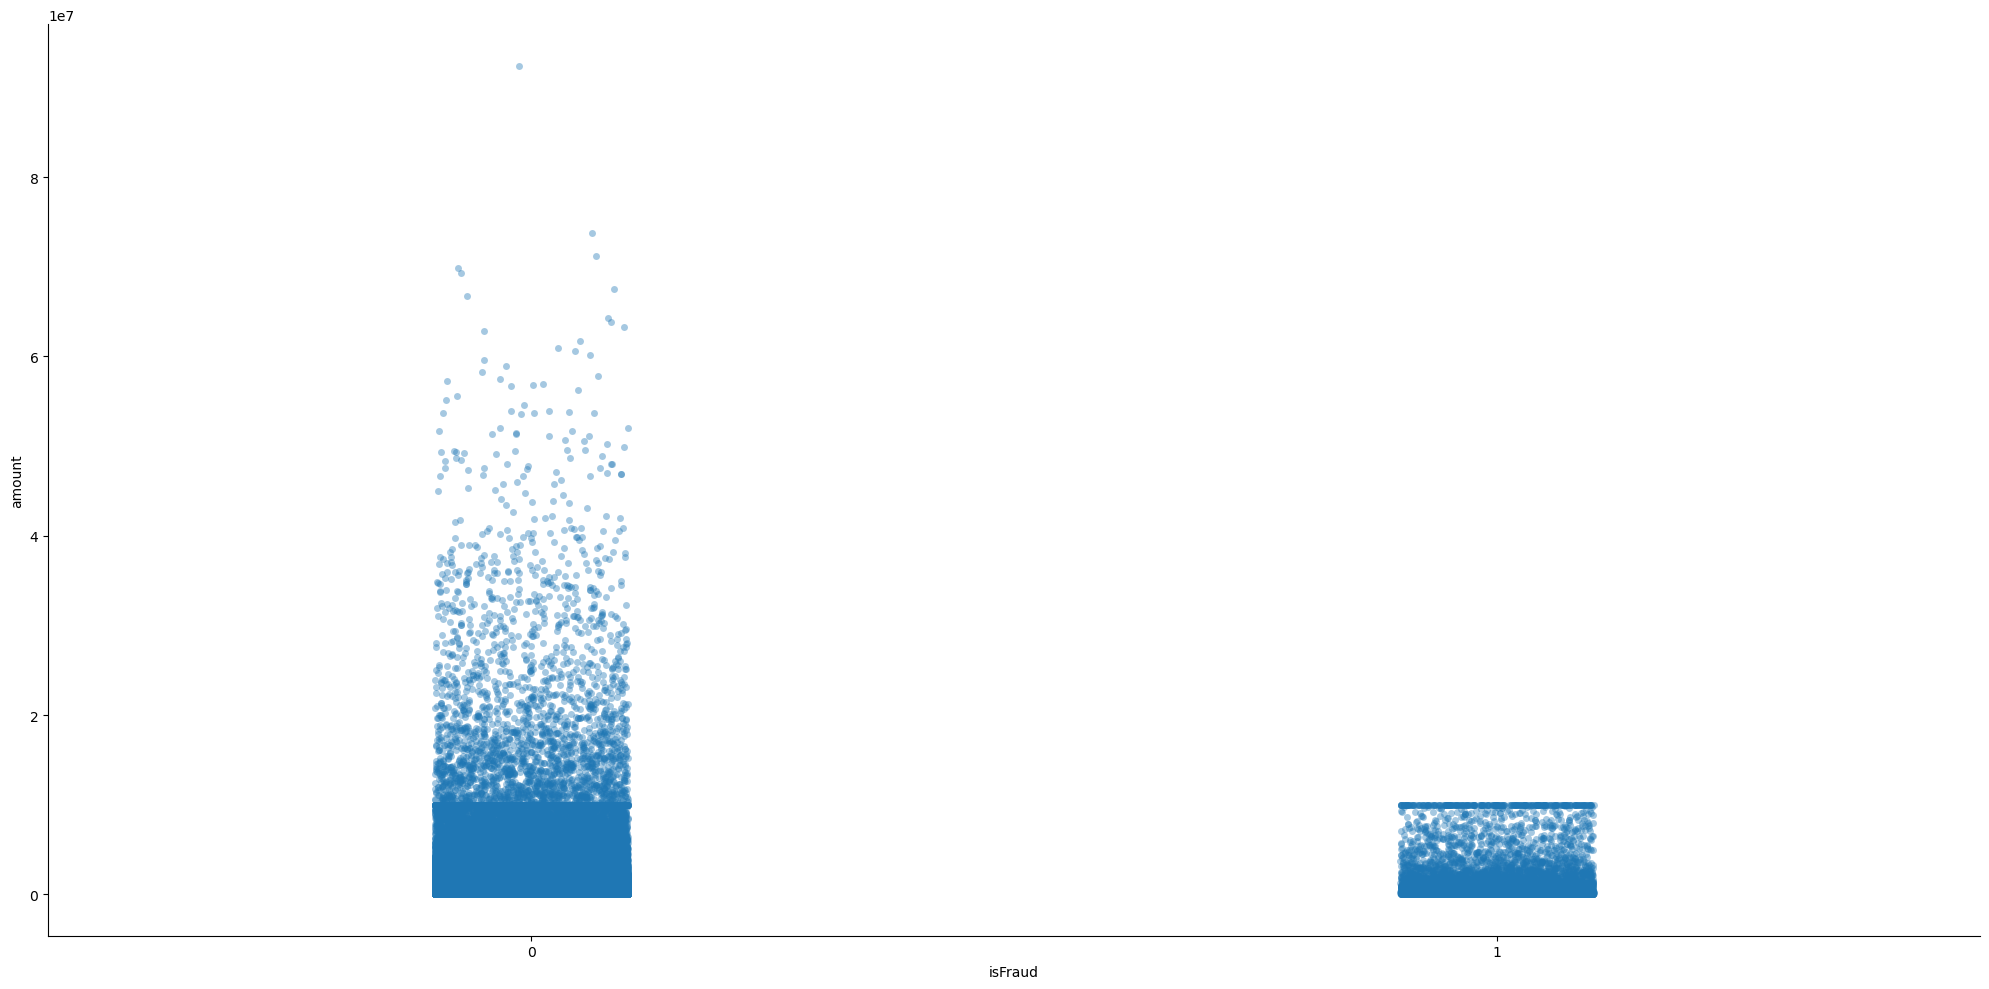

In [317]:
import seaborn as sns

sns.catplot(data=df, x = df.isFraud, y = df.amount, height = 10, aspect = 2, alpha = 0.4)

Here, we can see that the amount of `non-fraudulent` transactions can be little higher that the `fraudulent` ones, however nothing can be derived about the differences between the two based on `amount`.
<br>
##### 3. Balance variables:
We have already seen that there is a relationship between `fraudulent` transactions and `amount = 0`. We have also seen that a high number of transactions have inaccurately collected initial and final balances. Let us check these inaccuracies:

In [279]:
df['origBalance_inacc'] = (df['oldbalanceOrg'] - df['amount']) - df['newbalanceOrig']
df['destBalance_inacc'] = (df['oldbalanceDest'] + df['amount']) - df['newbalanceDest']

df[['origBalance_inacc', 'destBalance_inacc']]

/var/folders/w8/l7g1xptx17d36m8h5qskbkxc0000gn/T/ipykernel_978/2492156372.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['origBalance_inacc'] = (df['oldbalanceOrg'] - df['amount']) - df['newbalanceOrig']
/var/folders/w8/l7g1xptx17d36m8h5qskbkxc0000gn/T/ipykernel_978/2492156372.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['destBalance_inacc'] = (df['oldbalanceDest'] + df['amount']) - df['newbalanceDest']


,origBalance_inacc,destBalance_inacc
2,0.00,1.810000e+02
3,0.00,2.136300e+04
15,-213808.94,1.827035e+05
19,-214605.30,2.377353e+05
24,-300850.89,-2.401220e+06
...,...,...
6362615,0.00,0.000000e+00
6362616,0.00,6.311409e+06
6362617,0.00,1.000000e-02
6362618,0.00,8.500025e+05


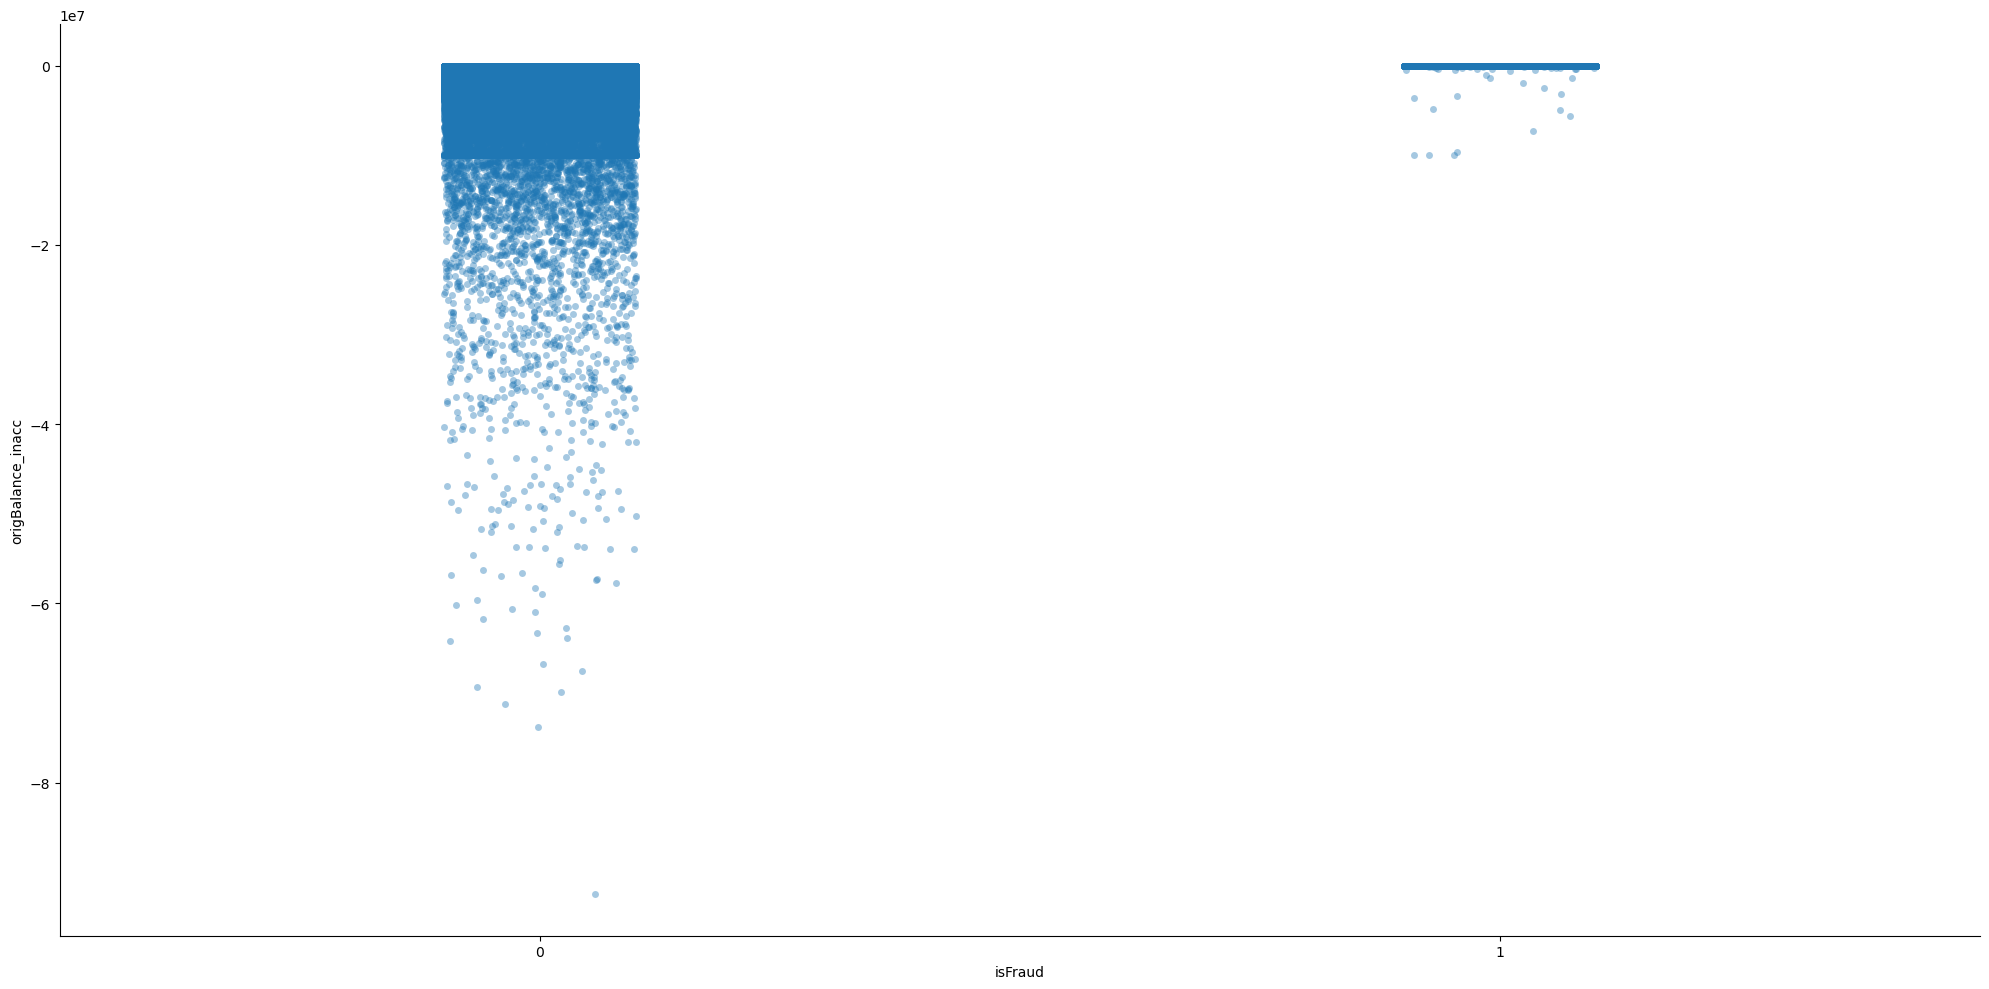

In [320]:
sns.catplot(data=df, x = df.isFraud, y = df.origBalance_inacc, height = 10, aspect = 2, alpha = 0.4)

<Figure size 2000x500 with 0 Axes>

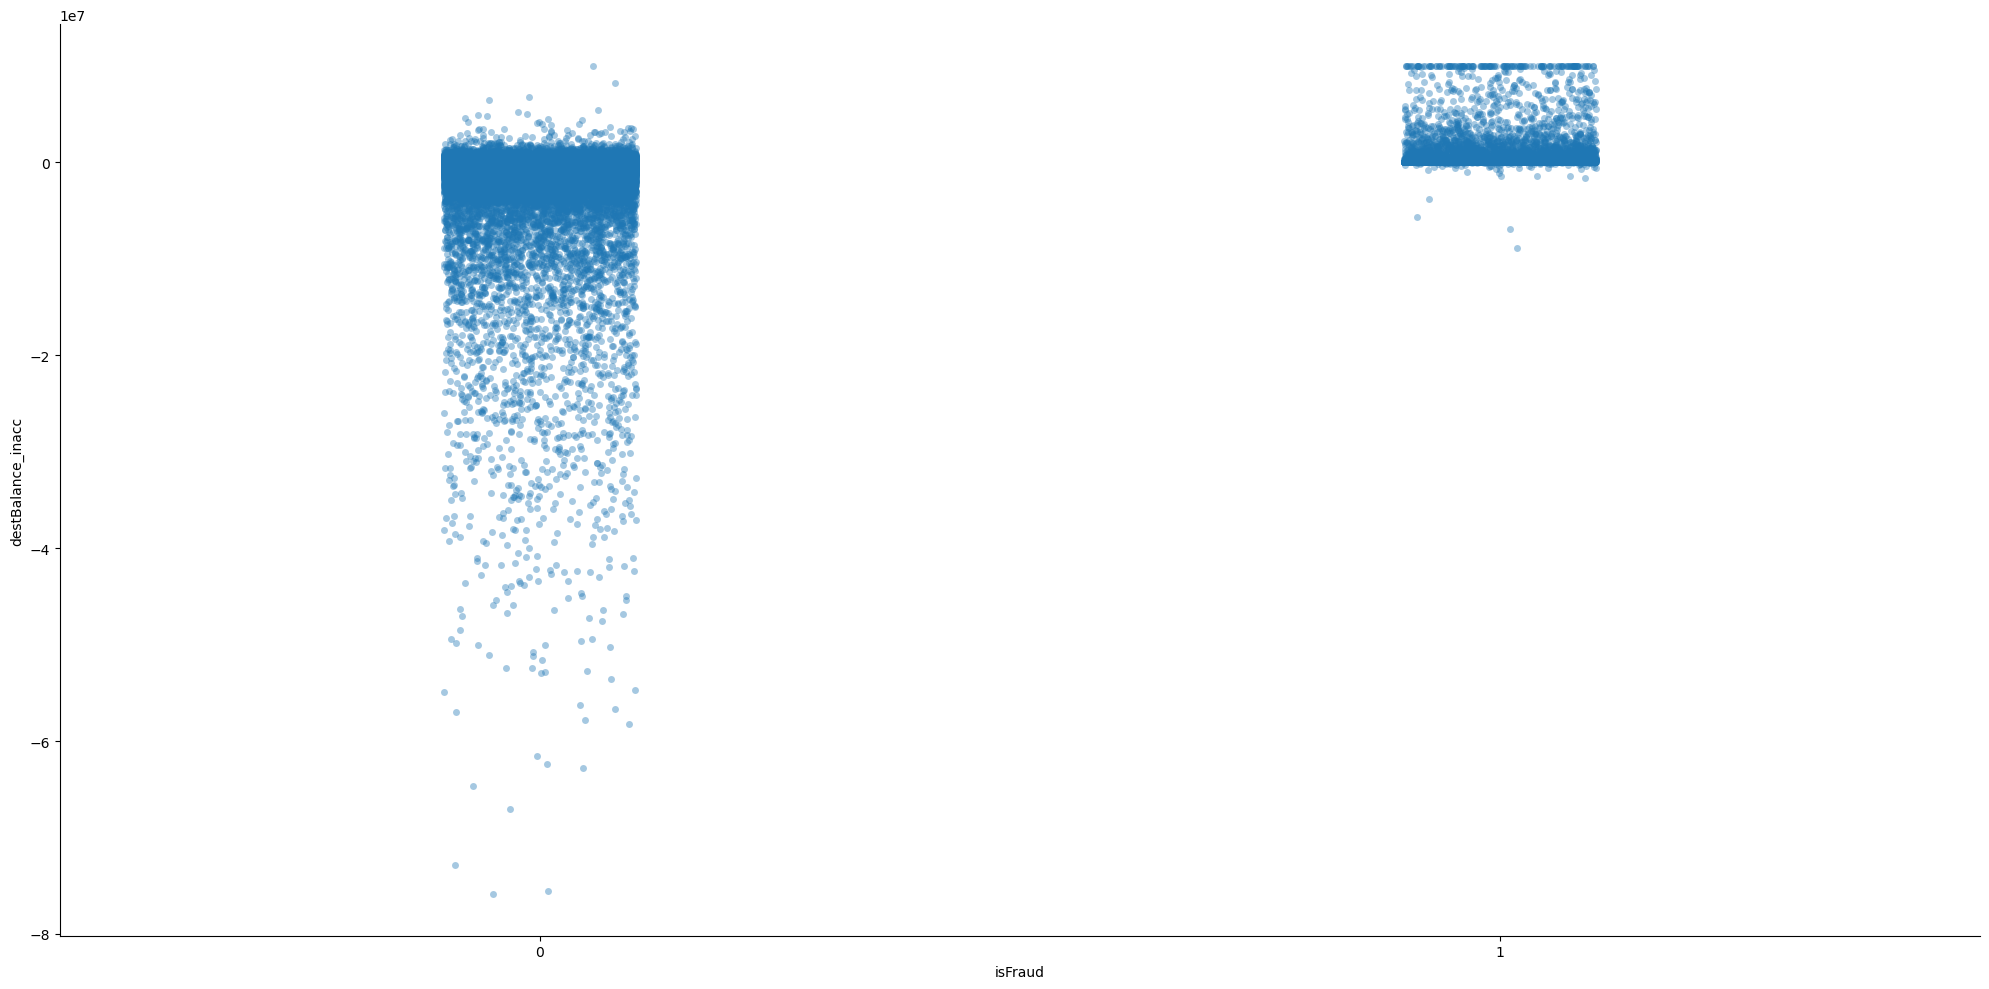

In [321]:
plt.figure(figsize=(20,5))
sns.catplot(data=df, x = df.isFraud, y = df.destBalance_inacc, height = 10, aspect = 2, alpha = 0.4)
plt.show()

It is safe to say we have found differences in the balance inaccuracies between fraudulent & non-fraudulent transactions.
<br><br>
In conclusion of the EDA, let us plot the explored separation between fraudulent and non-fraudulent transactions with respect to the `time step`, `balances` and `balance inaccuracies`.

<Axes: xlabel='destBalance_inacc', ylabel='step'>

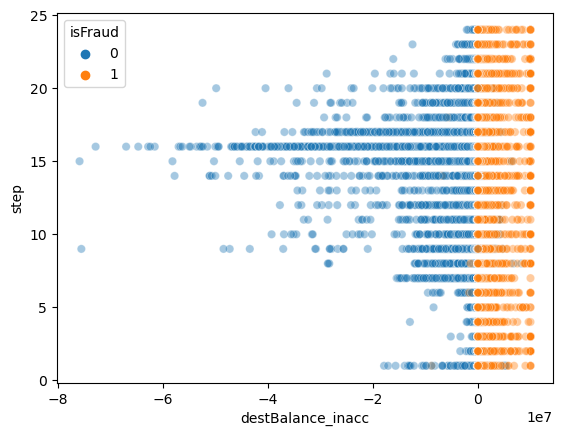

In [322]:
sns.scatterplot(data=df, x = df.destBalance_inacc, y = df.step, hue = df.isFraud, alpha = 0.4)

Calculating the correlation matrix:

/var/folders/w8/l7g1xptx17d36m8h5qskbkxc0000gn/T/ipykernel_978/3029092044.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  corr = df.corr()


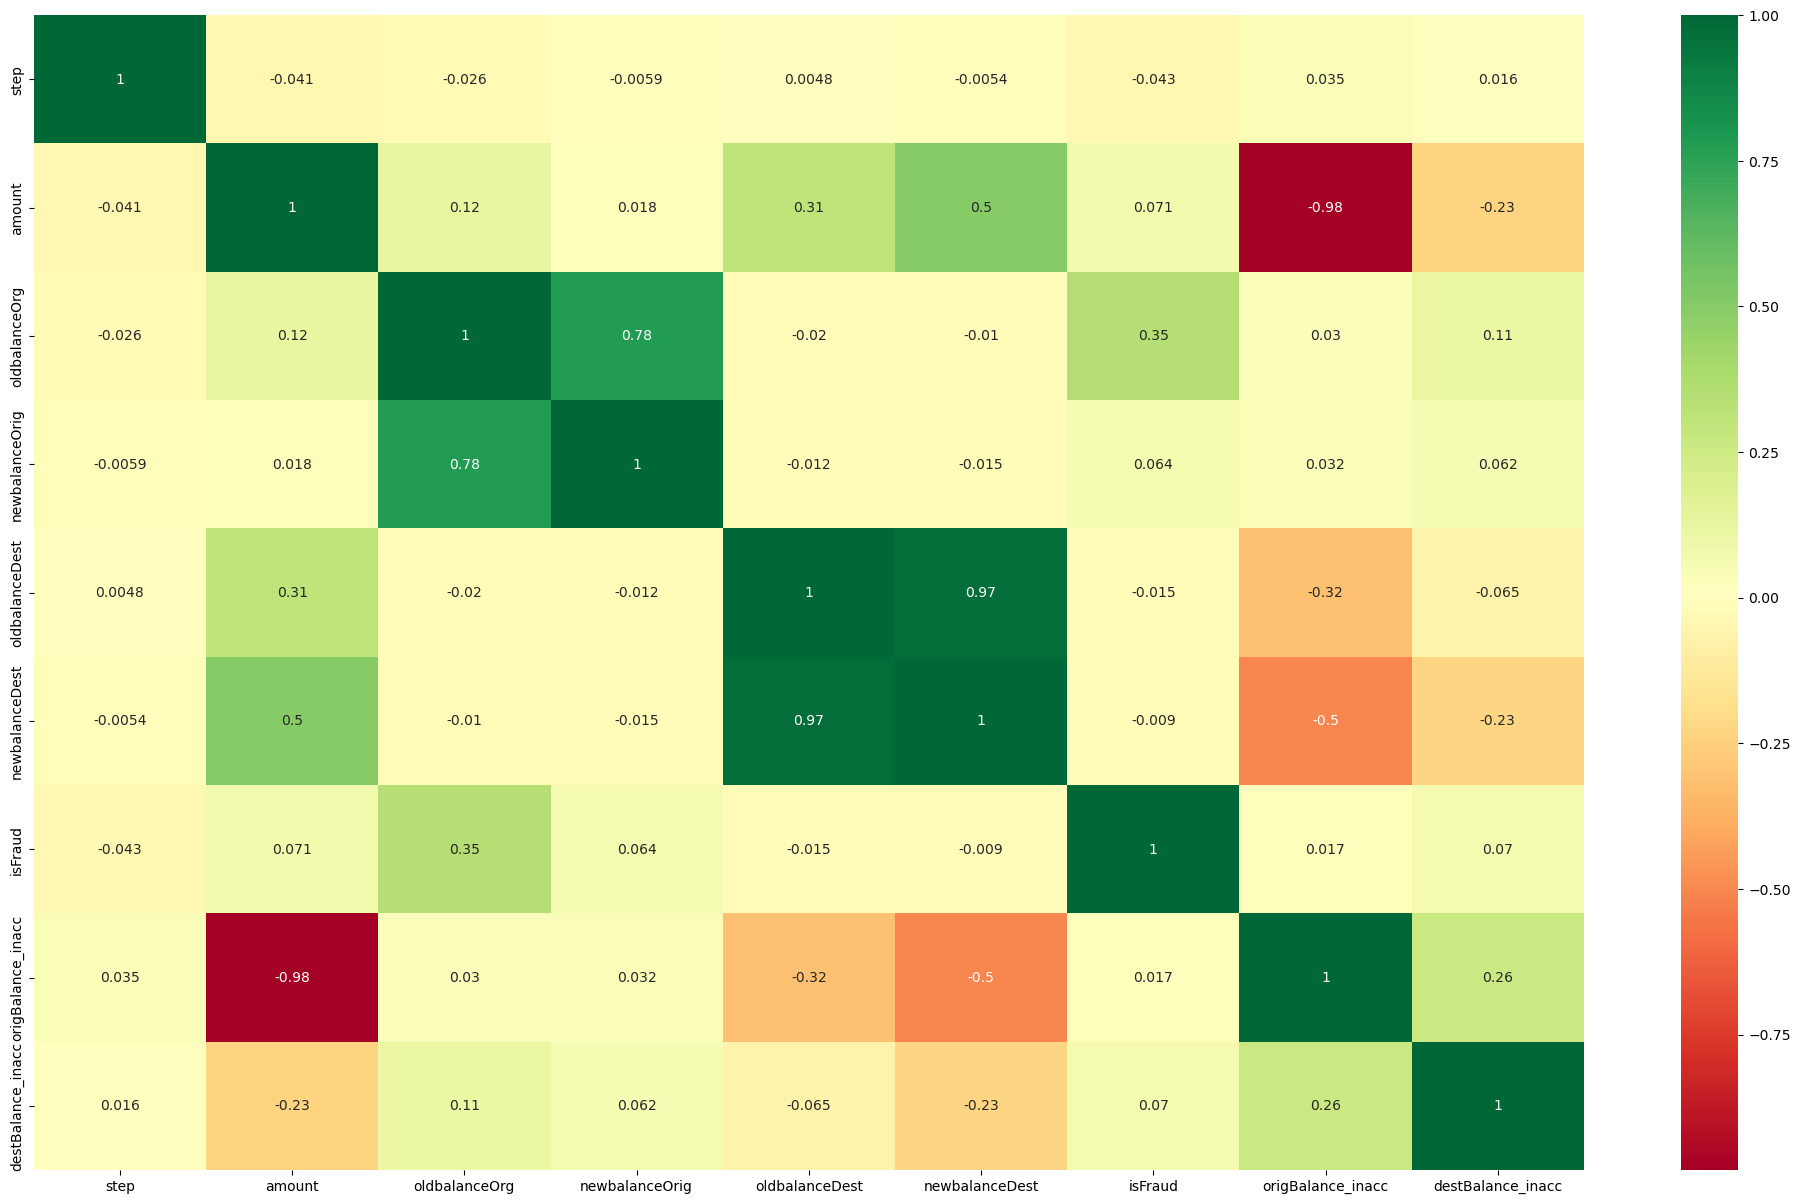

In [283]:
corr = df.corr()

plt.figure(figsize=(25, 15))
sns.heatmap(corr, annot=True, cmap='RdYlGn')
plt.show()

### Modeling

We first need to drop unnecessary variables.

In [284]:
df.drop(['newbalanceDest', 'newbalanceOrig', 'nameOrig', 'nameDest'], axis = 1, inplace = True)

/var/folders/w8/l7g1xptx17d36m8h5qskbkxc0000gn/T/ipykernel_978/399719482.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(['newbalanceDest', 'newbalanceOrig', 'nameOrig', 'nameDest'], axis = 1, inplace = True)


Then we move on to `one hot encoding` our categorical variable `type`.

In [285]:
df = pd.get_dummies(df, columns=['type'], prefix=['type'])
df.dtypes

step                   int64
amount               float64
oldbalanceOrg        float64
oldbalanceDest       float64
isFraud                int64
origBalance_inacc    float64
destBalance_inacc    float64
type_CASH_OUT          uint8
type_TRANSFER          uint8
dtype: object

We now need to standarize our data to scale all columns into the same range (except for the categorical features). We will use `StandardScaler` for this:

In [286]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

df_scaled = df.loc[:,~df.columns.isin(['isFraud', 'type_CASH_OUT', 'type_TRANSFER'])]
cols = df_scaled.columns
df_scaled = pd.DataFrame(std_scaler.fit_transform(df_scaled))
df_scaled.columns = cols
cols = cols.tolist()
cols.append('isFraud')
cols.append('type_CASH_OUT')
cols.append('type_TRANSFER')

df_scaled_new = pd.DataFrame(columns = [cols])
for i in df_scaled.columns:
    df_scaled_new[i] = df_scaled[i]

df_scaled_new.reset_index(drop=True, inplace = True)
df.reset_index(drop=True, inplace = True)

for i in ['type_CASH_OUT', 'type_TRANSFER', 'isFraud']:
    df_scaled_new[i] = df[i]

df_scaled_new


,step,amount,oldbalanceOrg,oldbalanceDest,origBalance_inacc,destBalance_inacc,isFraud,type_CASH_OUT,type_TRANSFER
0,-3.739278,-0.357467,-0.188847,-0.403155,0.326719,0.048575,1,0,1
1,-3.739278,-0.357467,-0.188847,-0.398142,0.326719,0.084266,1,1,0
2,-3.739278,-0.099576,-0.128591,-0.401952,0.082456,0.356121,0,1,0
3,-3.739278,-0.115146,-0.186762,-0.397848,0.081547,0.448849,0,0,1
4,-3.739278,-0.006590,-0.146456,-0.401672,-0.016983,-3.997735,0,0,1
...,...,...,...,...,...,...,...,...,...
2770404,1.947221,0.024945,1.161997,-0.403155,0.326719,0.048270,1,1,0
2770405,1.947221,6.751458,24.922965,-0.403155,0.326719,10.682860,1,0,1
2770406,1.947221,6.751458,24.922965,-0.386947,0.326719,0.048270,1,1,0
2770407,1.947221,0.599766,3.192516,-0.403155,0.326719,1.480506,1,0,1


Now we need to split our data into `train data` and `test data` (`70:30` split).

In [287]:
from sklearn.model_selection import train_test_split

X = df_scaled_new.drop(columns='isFraud')
Y = df_scaled_new['isFraud']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

/var/folders/w8/l7g1xptx17d36m8h5qskbkxc0000gn/T/ipykernel_978/221258485.py:3: PerformanceWarning: dropping on a non-lexsorted multi-index without a level parameter may impact performance.
  X = df_scaled_new.drop(columns='isFraud')


In [288]:
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
Y_train = label_encoder.fit_transform(Y_train.values.ravel())
Y_test = label_encoder.fit_transform(Y_test.values.ravel())

Now, we will move on to checking if the class imbalance is the similar in our training and testing sets.

In [289]:
frauds_train = 0
for i in Y_train:
    if i == 1:
        frauds_train += 1

frauds_test = 0
for i in Y_test:
    if i == 1:
        frauds_test += 1

print(f'Class imbalance - TRAIN: {round((frauds_train/len(Y_train) * 100), 3)}%, TEST: {round((frauds_test/len(Y_test) * 100), 3)}%')

Class imbalance - TRAIN: 0.296%, TEST: 0.297%


### 1. Logistic Regression

Firstly, to handle high imbalance among the two classes, we use `class_weights` which will allocate a different weight to each class depending on their majority or minority, hence penaliizng misclassification due to buiding of a biased model.

In [290]:
from sklearn.linear_model import LogisticRegression

lr = LogisticRegression(class_weight = 'balanced')
lr_model = lr.fit(X_train, Y_train)

In [291]:
Y_pred = lr_model.predict(X_test)

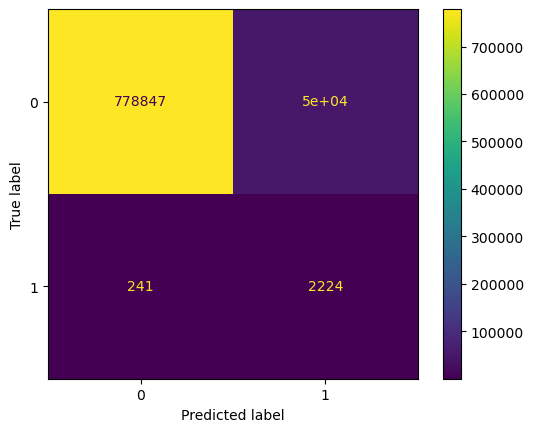

In [292]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(Y_test, Y_pred, labels=lr.classes_)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
cm_plot.plot()

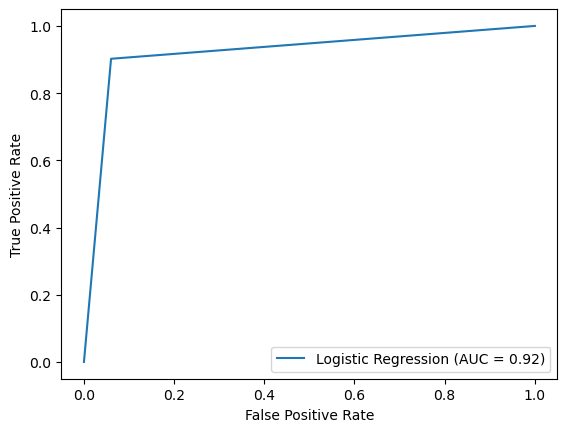

In [293]:
from sklearn.metrics import auc, roc_curve, RocCurveDisplay

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
roc_plot.plot()

In [294]:
from sklearn.metrics import classification_report

print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    828658
           1       0.04      0.90      0.08      2465

    accuracy                           0.94    831123
   macro avg       0.52      0.92      0.53    831123
weighted avg       1.00      0.94      0.97    831123



The famous metrics for any classification model calculated from the confusion matrix, for this `Logistic Regression` model with `class_weights="balanced"` are as follows:

In [295]:
from sklearn.metrics import recall_score, precision_score, f1_score, accuracy_score

print('Accuracy:', round(accuracy_score(Y_test, Y_pred), 3))
print('Precision:', round(precision_score(Y_test, Y_pred), 3), '', 'Recall:', round(recall_score(Y_test, Y_pred), 3))
print('F1 score:', round(f1_score(Y_test, Y_pred), 3))

Accuracy: 0.94
Precision: 0.043  Recall: 0.902
F1 score: 0.082


As we can see, our model has acheived an `accuracy` of about `94%` but it is not a good enough metric to base the success of the model.
Though the `recall` has come out to be `~0.902`, which means that of the total `isFraud=1` cases, our model has correctly identified `~90%`, the `precision` of the model is only `0.043`, meaning that out of the total cases predicted as `isFraud=1` by our model, only about `4.3%` were fraudulent in actuality.
The `F1-score` of the model is only `0.082`, which would identify our model as a bad fit for classifying the data at hand.<br><br>
We could perhaps retrain the model on the same data without using `class_weights="balanced"`, to see how it affects the models' metrics:

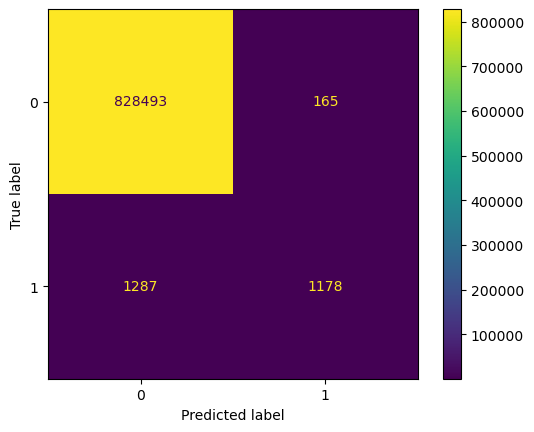

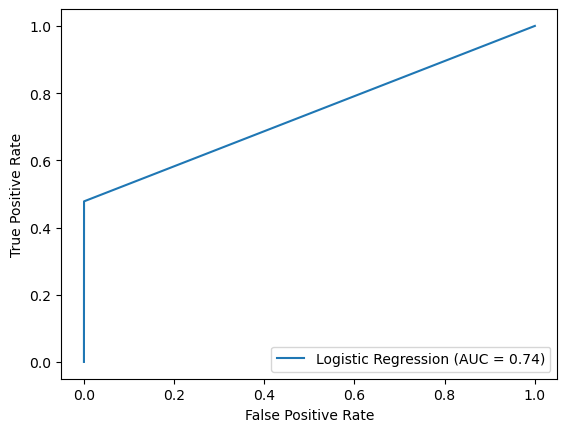

In [296]:
lr = LogisticRegression()
lr_model = lr.fit(X_train, Y_train)
Y_pred = lr_model.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred, labels=lr.classes_)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
cm_plot.plot()

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
roc_plot.plot()

In [297]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828658
           1       0.88      0.48      0.62      2465

    accuracy                           1.00    831123
   macro avg       0.94      0.74      0.81    831123
weighted avg       1.00      1.00      1.00    831123



The new Logistic Regression model with no handling of the present Class Imbalance actually gave a much better `F1-score`, of about `~0.62`. The `precision` of the new model is `~0.88`, which means that around `88%` of the `isFraud=1` predictions made are correct; on the other hand, the `recall` is down to `~0.48`, meaning that approximately `48%` of the actual fraudulent transactions were gone unidentified by our model.

The model is still not fit to classify query transactions as fraudulent or non-fraudulent, due to the presence of Class Imbalance and we shall now try handle the same using one of the popular methods—Random Undersampling, Random Oversampling, SMOTE, SMOTE ENN, SMOTE TOMEK, ADASYN, Imbalanced.

Let us try to address class imbalance using `Random Undersampling` for our Logistic Regression Model.

In [298]:
import numpy as np

fraud_train_ind = np.where(Y_train == 1)[0]
non_fraud_train_ind = np.where(Y_train == 0)[0]

non_fraud_train_ind_und = np.random.choice(non_fraud_train_ind, len(fraud_train_ind), replace = False)
non_fraud_train_ind_und = np.array(non_fraud_train_ind_und)

train_ind_und = np.concatenate([fraud_train_ind, non_fraud_train_ind_und])

X_train_und = X_train.loc[X_train.reset_index(drop=True).index.isin(train_ind_und),:]
Y_train_und = Y_train[train_ind_und.tolist()]

In [299]:
frauds_train = 0
for i in Y_train_und:
    if i == 1:
        frauds_train += 1

frauds_test = 0
for i in Y_test:
    if i == 1:
        frauds_test += 1

print(f'Class imbalance - TRAIN: {round((frauds_train/len(Y_train_und) * 100), 3)}%, TEST: {round((frauds_test/len(Y_test) * 100), 3)}%')

Class imbalance - TRAIN: 50.0%, TEST: 0.297%


We have successfully undersampled our training data and can now move on to preparing a Logistic Regression model on the undersampled training data.

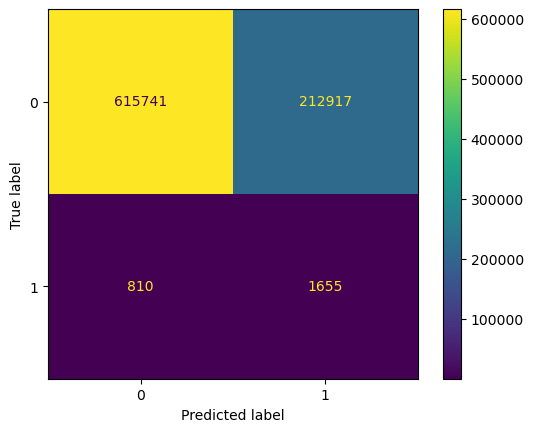

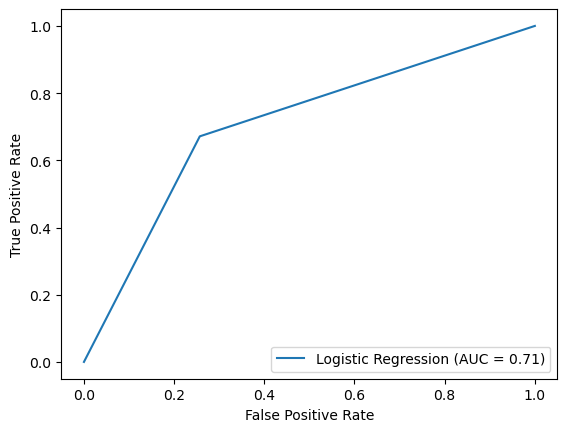

In [300]:
lr = LogisticRegression()
lr_model = lr.fit(X_train_und, Y_train_und)
Y_pred = lr_model.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred, labels=lr.classes_)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
cm_plot.plot()

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
roc_plot.plot()

In [301]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.74      0.85    828658
           1       0.01      0.67      0.02      2465

    accuracy                           0.74    831123
   macro avg       0.50      0.71      0.43    831123
weighted avg       1.00      0.74      0.85    831123



The above metrics of the latest model tell us that even after undersampling, our model is highly unfit to classify the data at hand.

Let us try to use the `Random Oversampling` technique for addressing Class Imabalance for our Logistic Regression model.

In [302]:
from imblearn.over_sampling import RandomOverSampler

ovr = RandomOverSampler(random_state=42)
X_train_ovr, Y_train_ovr = ovr.fit_resample(X_train, Y_train)


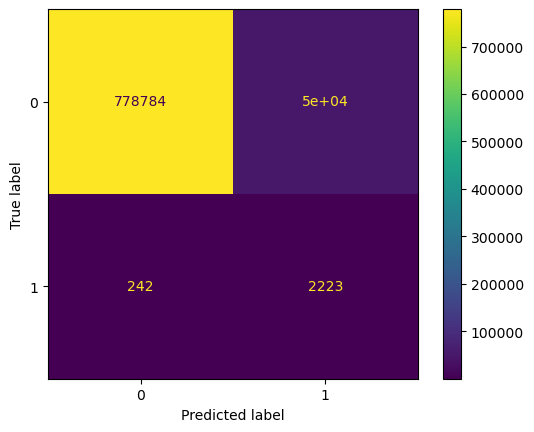

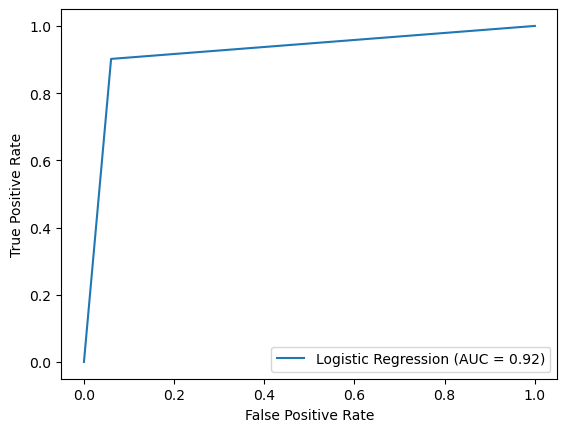

In [303]:
lr = LogisticRegression()
lr_model = lr.fit(X_train_ovr, Y_train_ovr)
Y_pred = lr_model.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred, labels=lr.classes_)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
cm_plot.plot()

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
roc_plot.plot()

In [304]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    828658
           1       0.04      0.90      0.08      2465

    accuracy                           0.94    831123
   macro avg       0.52      0.92      0.53    831123
weighted avg       1.00      0.94      0.97    831123



The above scores tell us that the method of Random Oversampling has increased the `recall` of our model but the `precision` is unacceptably low. 

We will now take a last shot at trying to fit this model addressing the imbalance using the `SMOTE` technique:

In [305]:
from imblearn.over_sampling import SMOTE

smote = SMOTE()

# fit predictor and target variable
X_train_SMOTE, Y_train_SMOTE = smote.fit_resample(X_train, Y_train)

# print('Original dataset shape', Counter(y))
# print('Resample dataset shape', Counter(y_ros))

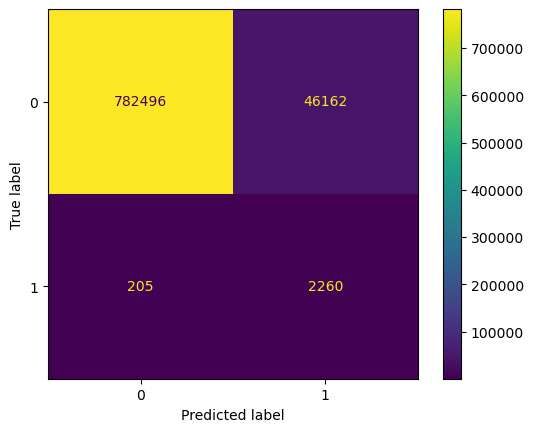

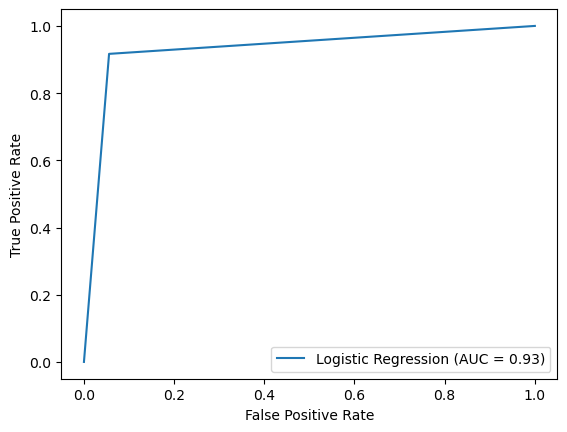

In [306]:
lr = LogisticRegression()
lr_model = lr.fit(X_train_SMOTE, Y_train_SMOTE)
Y_pred = lr_model.predict(X_test)

cm = confusion_matrix(Y_test, Y_pred, labels=lr.classes_)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=lr.classes_)
cm_plot.plot()

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Logistic Regression')
roc_plot.plot()

In [307]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      0.94      0.97    828658
           1       0.05      0.92      0.09      2465

    accuracy                           0.94    831123
   macro avg       0.52      0.93      0.53    831123
weighted avg       1.00      0.94      0.97    831123



These results show that even the `SMOTE` method is not being able to sufficiently help us make a 'good fitting' Logistic Regression model for our data, as we are not being able to find a good enough balance between `precision` and `recall`, abnd therefore the `F1-score` is unacceptably low.
Let us now move on to a different model, hopefully one which would be a better fit.
<br><br>
### 2. Random Forest

In [308]:
X = df.drop(columns='isFraud')
Y = df['isFraud']

X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.30, random_state=0)

In [309]:
from sklearn.ensemble import RandomForestClassifier

rf = RandomForestClassifier()
rf_model = rf.fit(X_train, Y_train)

rf_model.score(X_test, Y_test)

0.9994260777285673

We will now tune the `hyperparameters` of the `Radom Forest` model:

In [310]:
# rf_parameters = {
#     'n_estimators' : [i for i in range(0, 501, 50)],
#     'max_depth' : [4, 5, 1, 2, None],
#     'min_samples_split' : [2, 3, 4, 5],
#     'min_samples_leaf' : [1, 4, 10, 20],
#     'max_leaf_nodes' : [2, 5, 10, None]   
# }

# from sklearn.model_selection import RandomizedSearchCV

# rf_rscv = RandomizedSearchCV(rf, rf_parameters, cv=5, n_iter=5)
# rf_model_best = rf_rscv.fit(X_train, Y_train)

# rf_model_best.best_estimator_

## OUTPUT: RandomForestClassifier(min_samples_leaf=4, min_samples_split=4)

In [311]:
rf_best = RandomForestClassifier(min_samples_leaf=4, min_samples_split=4)

rf_model_best = rf_best.fit(X_train, Y_train)

In [312]:
Y_pred = rf_model_best.predict(X_test)

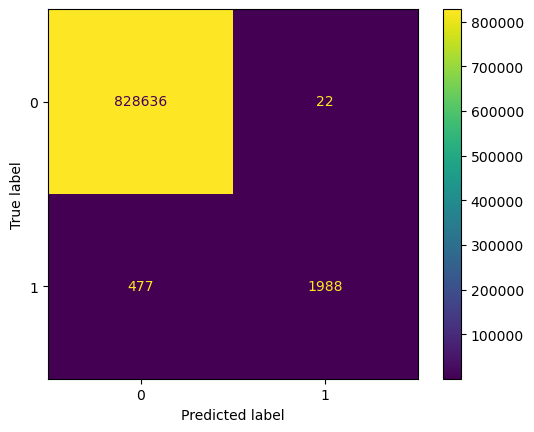

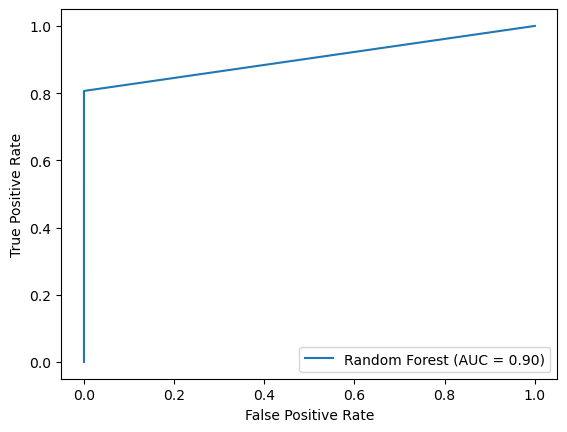

In [313]:
cm = confusion_matrix(Y_test, Y_pred, labels=rf_best.classes_)
cm_plot = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=rf_best.classes_)
cm_plot.plot()

fpr, tpr, thresholds = roc_curve(Y_test, Y_pred)
roc_auc = auc(fpr, tpr)
roc_plot = RocCurveDisplay(fpr=fpr, tpr=tpr, roc_auc=roc_auc, estimator_name='Random Forest')
roc_plot.plot()

In [314]:
print(classification_report(Y_test, Y_pred))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    828658
           1       0.99      0.81      0.89      2465

    accuracy                           1.00    831123
   macro avg       0.99      0.90      0.94    831123
weighted avg       1.00      1.00      1.00    831123



In [315]:
print('Accuracy:', round(accuracy_score(Y_test, Y_pred), 3))
print('Precision:', round(precision_score(Y_test, Y_pred), 3), '', 'Recall:', round(recall_score(Y_test, Y_pred), 3))
print('F1 score:', round(f1_score(Y_test, Y_pred), 3))

Accuracy: 0.999
Precision: 0.989  Recall: 0.806
F1 score: 0.888


As can be seen from the above results, the `Random Forest Classifier` has acheived an `accuracy` of `~0.999`, which is an impressive score, but not a sufficiently satisfying metric to base a model as a 'good fit'. 
So, we move on to the other important metric—the model has achieved an `F1-score` of nearly `0.888`, and `AUC ~= 0.90`, which sufficiently places our model as an <b>excellent fit<b> for our data.


---